In [10]:
import sys
sys.path.append('../Data_Feature')
sys.path.append('../Data_processing')
import numpy as np
import pandas as pd
from sklearn.multioutput import MultiOutputClassifier  # <-- ADD THIS
from sklearn.model_selection import GridSearchCV, LeaveOneOut, train_test_split, cross_val_predict, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, matthews_corrcoef, make_scorer, confusion_matrix, classification_report
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from data_processing import KOProcessor 
import networkx as nx
from pyvis.network import Network
from bioservices import KEGG
import multiprocessing
import warnings
import logging
import seaborn

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [21]:
# Global Params
estimator_configs = [
    {
        'name': 'RandomForest',
        'params': {

            'estimator': [MultiOutputClassifier(RandomForestClassifier(random_state=42))],  # <-- Wrap with MultiOutput
            'estimator__estimator__n_estimators': [100, 200, 300],  # <-- Nested parameter
            'estimator__estimator__max_depth': [5, 10, 15, None]
        }
    },
    {
        'name': 'SVC',
        'params': {

            'estimator': [MultiOutputClassifier(SVC(random_state=42))],  # <-- Wrap with MultiOutput
            'estimator__estimator__C': [0.1, 1, 10],
            'estimator__estimator__kernel': ['linear', 'rbf'],
            'estimator__estimator__gamma': ['scale', 'auto'],
            'estimator__estimator__class_weight': [None, 'balanced']
        }
    },
    {
        'name': 'LogisticRegression',
        'params': {

            'estimator': [MultiOutputClassifier(LogisticRegression())],  # <-- Wrap with MultiOutput
            'estimator__estimator__C': [0.01, 0.1, 1, 10, 100]
        }
    }
]

# Simplified param_grid (remove BernoulliNB for multiclass)
param_grid = [
    {  
        'estimator': [MultiOutputClassifier(RandomForestClassifier(random_state=42))],
        'estimator__estimator__n_estimators': [100, 200, 300],  
        'estimator__estimator__max_depth': [5, 10, 15, None]  
    },
    {  
        'estimator': [MultiOutputClassifier(SVC(random_state=42))],
        'estimator__estimator__C': [0.1, 1, 10],  
        'estimator__estimator__kernel': ['linear', 'rbf'], 
        'estimator__estimator__gamma': ['scale', 'auto'],
        'estimator__estimator__class_weight': [None, 'balanced']
    },
    {
        'estimator': [MultiOutputClassifier(LogisticRegression())],
        'estimator__estimator__C': [0.01, 0.1, 1, 10, 100]
    }         
]

# Define target traits (now a list)
target_traits = ['gram', 'oxygen']  

In [ ]:
# Load and preprocess data
terms_zip_path = 'C:/Users/eliah/Documents/Master/Eliah-Masters/Datasets/terms_KO.zip'
terms_csv_path = 'terms_KO.csv'
traits_reduced_zip_path = 'C:/Users/eliah/Documents/Master/Eliah-Masters/Datasets/reducedDataset.zip'
traits_reduced_csv_path = 'reducedDataset.csv'
traits_assembled_zip_path = 'C:/Users/eliah/Documents/Master/Eliah-Masters/Datasets/assembledDataset.zip'
traits_assembled_csv_path = 'assembledDataset.csv'

processor = KOProcessor(
    terms_zip_path, 
    terms_csv_path, 
    traits_reduced_zip_path, 
    traits_reduced_csv_path, 
    traits_assembled_zip_path=traits_assembled_zip_path, 
    traits_assembled_csv_path=traits_assembled_csv_path
)

ko_terms = processor.load_terms()
if ko_terms is None:
    raise FileNotFoundError("KO terms could not be loaded. Please check the file paths.")

reduced_traits_data = processor.load_reduced_traits_data()
if reduced_traits_data is None:
    raise FileNotFoundError("Reduced traits data could not be loaded. Please check the file paths.")

# Preprocess KO terms
X_terms = processor.preprocess_terms(ko_terms)

# Preprocess all target traits into a DataFrame
y_dfs = []
for trait in target_traits:
    y_trait = processor.preprocess_traits(reduced_traits_data, trait_column=trait, use_assembled_if_missing=True)
    if y_trait is not None:
        y_dfs.append(y_trait.rename(trait))

y_combined = pd.concat(y_dfs, axis=1).dropna()

# Align features with labels
X_aligned, Y_aligned = processor.align_data(X_terms, y_combined)

# Feature Selection: Variance Threshold
selector = VarianceThreshold(threshold=0.03)
X_aligned = selector.fit_transform(X_aligned)

# Check trait distributions
for trait in target_traits:
    print(f"\nDistribution for {trait}:")
    print(Y_aligned[trait].value_counts())

Data loaded successfully:
   Unnamed: 0   key      KO
0           0  1000  K00001
1           1  1000  K13954
2           2  1000  K00003
3           3  1000  K00013
4           4  1000  K00014
Data loaded successfully:
   key        ID                      speciesStrain  \
0    1  592010.0   Abiotrophia defectiva ATCC 49176   
1    1     219.0     Abiotrophia defectiva DSM 9849   
2    2  159837.0       Abyssibacter profundi OUC007   
3    3       NaN  Acanthopleuribacter pedis FYK2218   
4    4  258515.0   Acetanaerobacterium elongatum Z7   

                 speciesStrainComp                genus            genusComp  \
0    abiotrophiadefectivaatcc49176          Abiotrophia          abiotrophia   
1      abiotrophiadefectivadsm9849          Abiotrophia          abiotrophia   
2       abyssibacterprofundiouc007         Abyssibacter         abyssibacter   
3  acanthopleuribacterpedisfyk2218  Acanthopleuribacter  acanthopleuribacter   
4   acetanaerobacteriumelongatumz7  Acetanaerobac

Fitting 5 folds for each of 41 candidates, totalling 205 fits


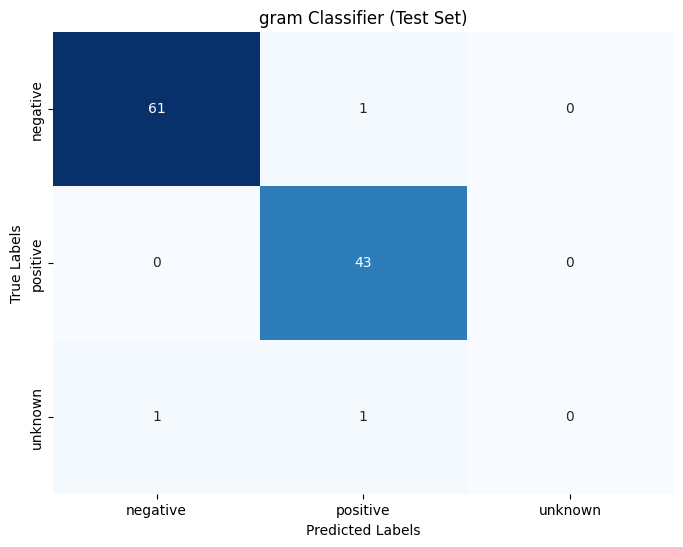

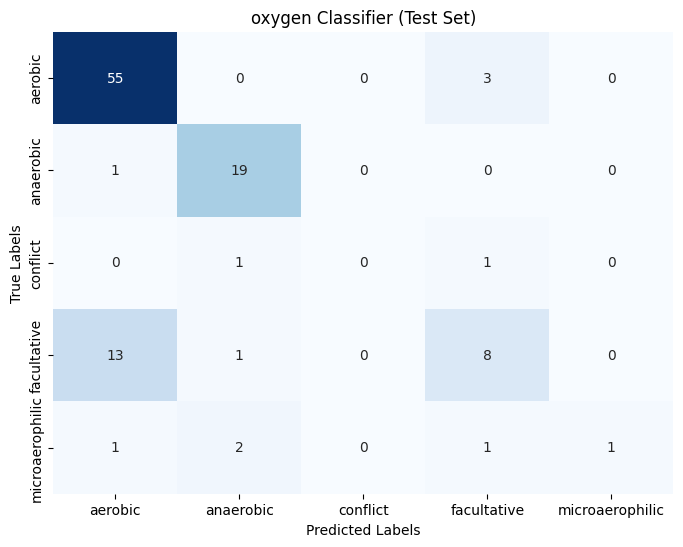


Classification Report for gram:
              precision    recall  f1-score   support

    negative       0.98      0.98      0.98        62
    positive       0.96      1.00      0.98        43
     unknown       0.00      0.00      0.00         2

    accuracy                           0.97       107
   macro avg       0.65      0.66      0.65       107
weighted avg       0.95      0.97      0.96       107


Classification Report for oxygen:
                 precision    recall  f1-score   support

        aerobic       0.79      0.95      0.86        58
      anaerobic       0.83      0.95      0.88        20
       conflict       0.00      0.00      0.00         2
    facultative       0.62      0.36      0.46        22
microaerophilic       1.00      0.20      0.33         5

       accuracy                           0.78       107
      macro avg       0.65      0.49      0.51       107
   weighted avg       0.75      0.78      0.74       107



In [26]:
#############################################
# Modified Functions for Multi-Output
#############################################

def plot_confusion_matrix(cm, title, class_labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues', 
        cbar=False, 
        xticklabels=class_labels, 
        yticklabels=class_labels
    )
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

def plot_multitrait_confusion_matrices(Y_true, Y_pred, target_traits):
    """Plots confusion matrices for each trait."""
    for idx, trait in enumerate(target_traits):
        y_true = Y_true.iloc[:, idx]
        y_pred = Y_pred.iloc[:, idx]
        cm = confusion_matrix(y_true, y_pred)
        class_labels = sorted(y_true.unique())
        plot_confusion_matrix(cm, f"{trait} Classifier (Test Set)", class_labels)

def train_and_evaluate_multitrait(X_aligned, Y_aligned, target_traits, test_size=0.2, random_state=42):
    results = {}
    logging.info(f"Processing traits: {target_traits}")
    
    # Split data (no stratification for simplicity)
    X_train, X_test, Y_train, Y_test = train_test_split(
        X_aligned, Y_aligned, test_size=test_size, random_state=random_state
    )
    logging.info(f"Data split: {X_train.shape[0]} training samples, {X_test.shape[0]} test samples.")
    
    # Pipeline WITHOUT feature selection for multi-label classification
    pipeline = Pipeline([
        ('estimator', MultiOutputClassifier(RandomForestClassifier(random_state=42)))
    ])
    
    
    # Grid Search
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, Y_train)
    
    logging.info(f"Best parameters: {grid_search.best_params_}")
    logging.info(f"Best CV score: {grid_search.best_score_:.3f}")
    
    # Test Set Evaluation
    Y_pred_test = grid_search.best_estimator_.predict(X_test)
    Y_pred_test_df = pd.DataFrame(Y_pred_test, columns=Y_test.columns, index=Y_test.index)
    
    # Per-trait metrics
    for trait in target_traits:
        mcc = matthews_corrcoef(Y_test[trait], Y_pred_test_df[trait])
        f1 = f1_score(Y_test[trait], Y_pred_test_df[trait], average='macro')
        logging.info(f"{trait} - Test MCC: {mcc:.3f}, F1: {f1:.3f}")
    
    # Confusion Matrices per Trait
    plot_multitrait_confusion_matrices(Y_test, Y_pred_test_df, target_traits)
    
    # Classification Report per Trait
    for trait in target_traits:
        print(f"\nClassification Report for {trait}:")
        print(classification_report(Y_test[trait], Y_pred_test_df[trait]))
    
    return results

# Run the multi-label pipeline
results = train_and_evaluate_multitrait(X_aligned, Y_aligned, target_traits)


In [ ]:

# KEGG Pathway Mapping
def map_ko_to_pathways(ko_terms):
    kegg = KEGG()
    pathways = {}
    for ko in ko_terms:
        try:
            gene_links = kegg.link("pathway", ko)
            if gene_links:
                for entry in gene_links.strip().split("\n"):
                    split_entry = entry.split("\t")
                    if len(split_entry) >= 2:
                        ko_id, pathway_id = split_entry[0], split_entry[1]
                        if pathway_id not in pathways:
                            pathways[pathway_id] = set()
                        pathways[pathway_id].add(ko)
        except Exception as e:
            print(f"Error processing {ko}: {e}")
    return pathways

selected_important_features = X_terms.columns[selector.get_support()]
pathways = map_ko_to_pathways(selected_important_features)

# Creating the adjacency matrix with translated KO terms, including original KO term
translated_kos = {ko: f"Translated_{ko}" for ko in selected_important_features}  # Placeholder for actual translation function
pathway_matrix = pd.DataFrame(
    index=[f"{translated_kos[ko]} ({ko})" for ko in selected_important_features],
    columns=pathways.keys(),
    data=0
)
for pathway, kos in pathways.items():
    for ko in kos:
        if ko in selected_important_features:
            pathway_matrix.loc[f"{translated_kos[ko]} ({ko})", pathway] = 1

# Fetch and rename pathway names for readability
kegg = KEGG()
for column in pathway_matrix.columns:
    pathway_info = kegg.get(column)
    parsed_info = kegg.parse(pathway_info)
    pathway_name = parsed_info['NAME'][0] if 'NAME' in parsed_info else column
    pathway_matrix.rename(columns={column: pathway_name}, inplace=True)

print("Pathway matrix after renaming:\n", pathway_matrix)

# Heatmap visualization
sns.heatmap(pathway_matrix, annot=True, cmap="Greys", cbar=False)
plt.title(f'Adjacency Matrix of KO Terms and Pathways (Multilabel)')
plt.xlabel('Pathways')
plt.ylabel('KO Terms')
plt.show()

# Network Visualization
G = nx.Graph()

# Define a list of general pathways to exclude
excluded_pathways = ["metabolic pathways"]  # You can add more general terms here

# Add nodes and edges with renamed pathway names
for ko in selected_important_features:
    translated_label = f"{translated_kos[ko]} ({ko})"
    G.add_node(ko, title=translated_label, label=translated_label, color='red', size=20)

for pathway_id, kos in pathways.items():
    pathway_info = kegg.get(pathway_id)
    parsed_info = kegg.parse(pathway_info)
    pathway_name = parsed_info['NAME'][0] if 'NAME' in parsed_info else pathway_id
    if pathway_name.lower() not in excluded_pathways:
        G.add_node(pathway_name, title=pathway_name, label=pathway_name, color='blue', size=30)
        for ko in kos:
            G.add_edge(ko, pathway_name)

# Pyvis network visualization
nt = Network("800px", "1200px", notebook=True, heading=f'Interactive Network of KO Terms and Pathways (Multilabel)', bgcolor="#ffffff", font_color="black", cdn_resources='remote')
nt.from_nx(G)
nt.toggle_physics(True)
nt.show_buttons(filter_=['physics'])
nt.save_graph
